## Step #1 : Camera Calibration ✅

We will first determine the intrinsic parameters of our cameras and their relative positions.

Camera Calibration using chessboard left images:

chessboards\c1Left.png


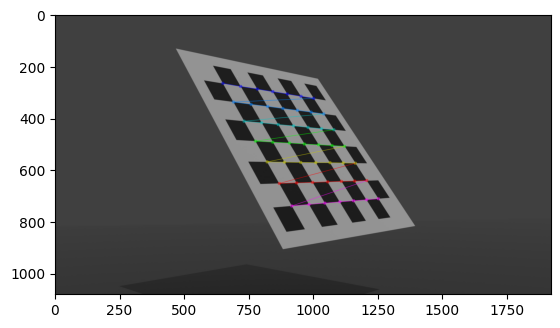

chessboards\c2Left.png


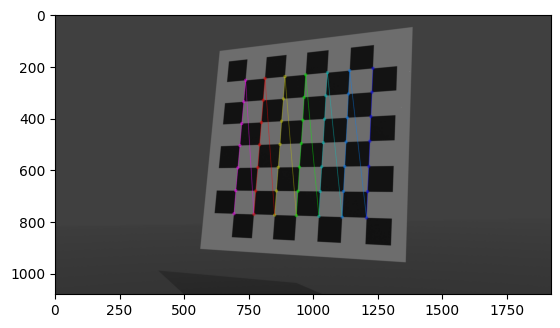

chessboards\c3Left.png


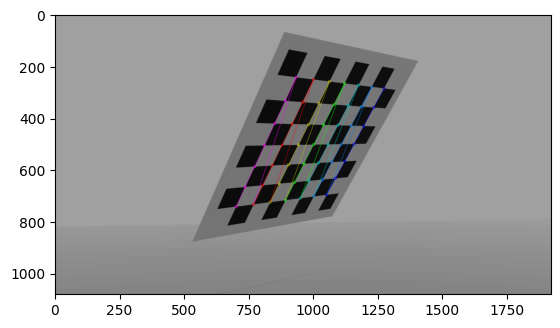

chessboards\c4Left.png


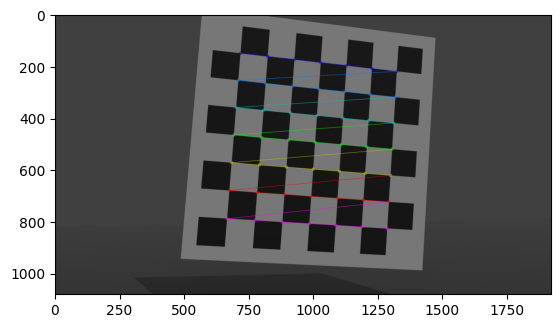

Camera Calibration using chessboard right images:

chessboards\c1Right.png


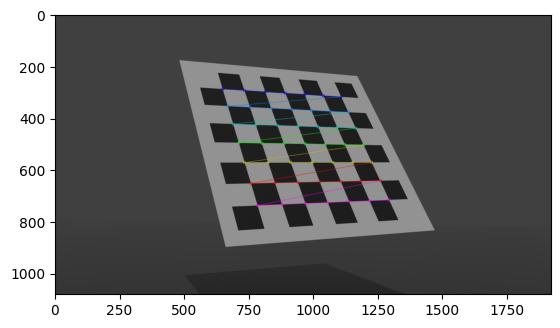

chessboards\c2Right.png


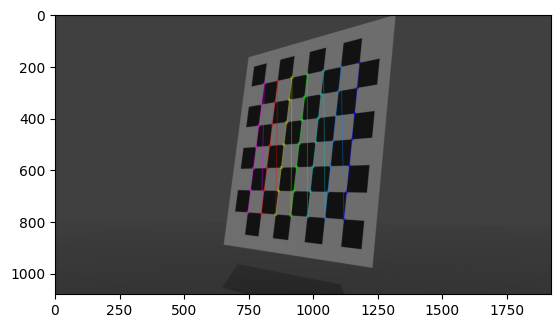

chessboards\c3Right.png


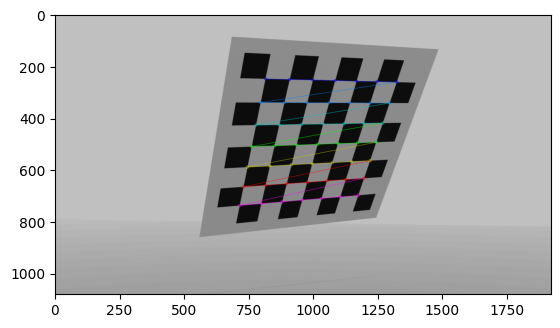

chessboards\c4Right.png


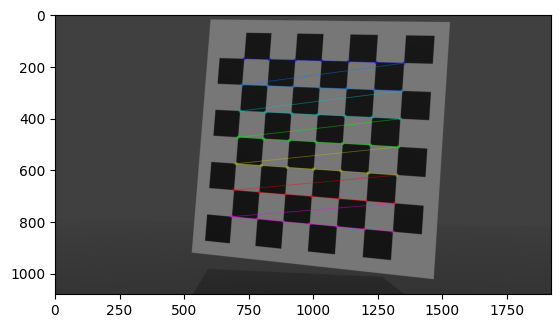

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calibrate_camera(images, chessboard_size):
    obj_points = []  # 3D points in real-world space
    img_points = []  # 2D points in image plane
    
    # Prepare object points: (0,0,0), (1,0,0), ..., (chessboard_size[0]-1, chessboard_size[1]-1, 0)
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    
    image_size = (1920,1080)  # To store the size of the images
    
    # Process each image
    for file in images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size)
        if ret:
            img_points.append(corners)
            obj_points.append(objp)
            # termination criteria for the cornerSubPix algorithm
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            # Optionally refine corners
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
            print(file)
            plt.imshow(img)
            plt.show()
    
    # Calibrate the camera
    ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_size, None, None)
    return ret, cameraMatrix, dist, rvecs, tvecs, img_points

# Chessboard images location
chessboard_left_images = sorted(glob.glob('chessboards/*Left.png'))
chessboard_right_images = sorted(glob.glob('chessboards/*Right.png'))

chessboard_size = (7, 7) # Pour un chéquier 8x8 car on spécifie le nombre de coins intérieurs

# CAMERA CALIBRATION
print("Camera Calibration using chessboard left images:\n")
retL, cameraMatrixL, distL, rvecsL, tvecsL, imagePointsL  = calibrate_camera(chessboard_left_images, chessboard_size)
print("Camera Calibration using chessboard right images:\n")
retR, cameraMatrixR, distR, rvecsR, tvecsR, imagePointsR = calibrate_camera(chessboard_right_images, chessboard_size)

## Step #2 : Projection Matrices ✅

Next we need to compute the cameras' projection matrices.

In [2]:
def get_projection_matrix(cameraMatrix, rvecs, tvecs):
    R, _ = cv2.Rodrigues(rvecs) # Convert rotation vector to matrix
    extrinsic_matrix = np.hstack((R, tvecs)) # Combine rotation and translation
    return np.dot(cameraMatrix, extrinsic_matrix)

# Projection matrices
projMatL = get_projection_matrix(cameraMatrixL, rvecsL[0], tvecsL[0])
projMatR = get_projection_matrix(cameraMatrixR, rvecsR[0], tvecsR[0])

print("Projection matrices: \n", projMatL)
print("\n", projMatR)

Projection matrices: 
 [[ 2.06355251e+03  6.06547854e+02 -8.39946715e+02  1.42330411e+04]
 [ 4.65096927e+02  1.43122504e+03  1.56046499e+03  5.87111372e+03]
 [ 7.79216216e-01 -4.01567940e-01  4.81212301e-01  2.19552228e+01]]

 [[ 2.30350682e+03  8.88640312e+01 -1.31769650e+02  1.50558761e+04]
 [ 2.70172867e+02  1.33214469e+03  1.68929698e+03  6.71755030e+03]
 [ 4.77041606e-01 -5.55333433e-01  6.81201941e-01  2.32615876e+01]]


## Step #3 : Fundamental Matrix ✅

Compute fundamental matrix.

In [3]:
def compute_fundamental_matrix(img_points_left, img_points_right):
    pts_left = np.array([pt.ravel() for pts in img_points_left for pt in pts])
    pts_right = np.array([pt.ravel() for pts in img_points_right for pt in pts])
    
    # Compute the fundamental matrix using matched points from the left and right images.
    F, mask = cv2.findFundamentalMat(pts_left, pts_right, method=cv2.FM_RANSAC)
    return F, mask
    
F, mask = compute_fundamental_matrix(imagePointsL, imagePointsR)

print("Fundamental Matrix:\n", F)

Fundamental Matrix:
 [[ 4.07852709e-10  7.84673364e-07 -5.09025990e-04]
 [ 8.45744105e-07 -1.05274404e-08 -9.32221537e-03]
 [-5.44381768e-04  7.78379820e-03  1.00000000e+00]]


## Step #4 : Red Lines Sampling ✅

The red lines are sampled for the pairing process.

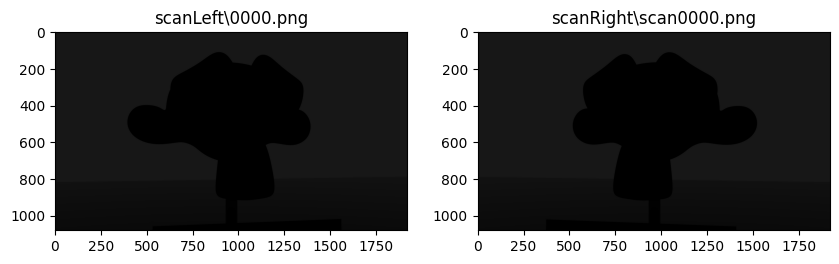

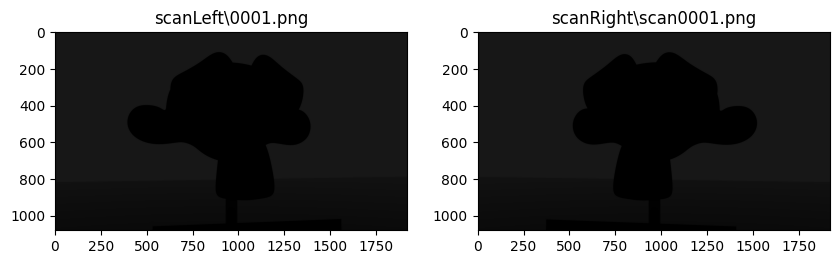

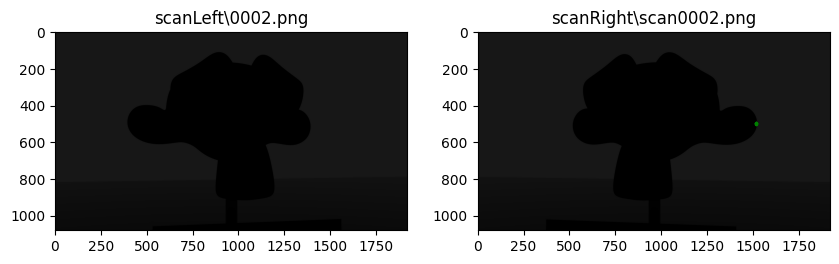

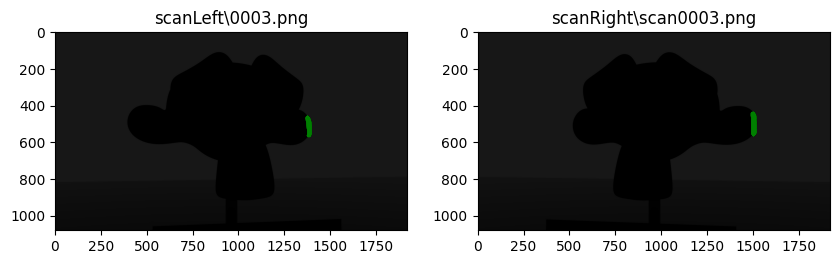

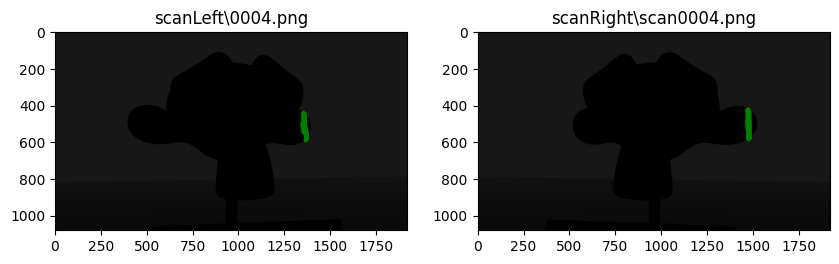

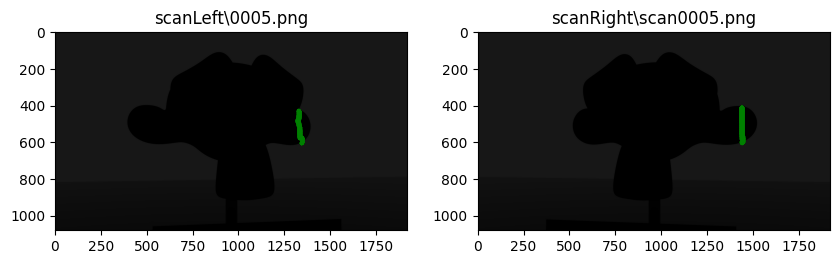

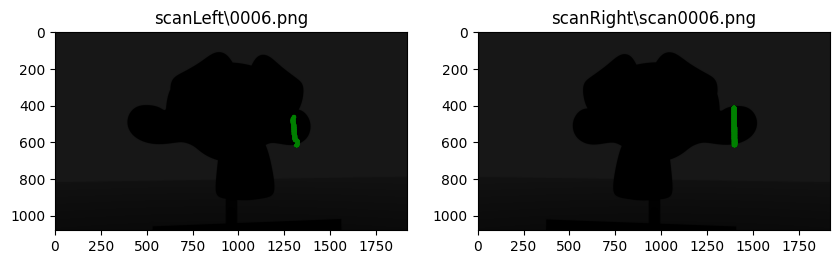

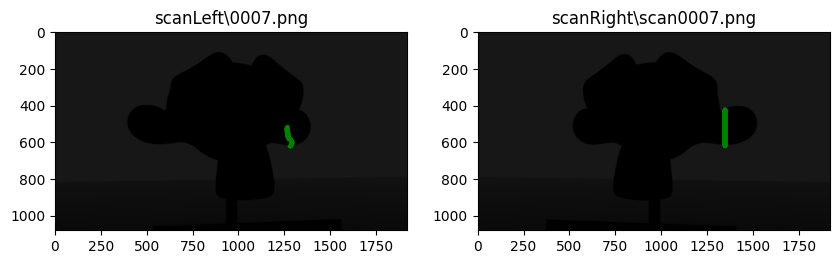

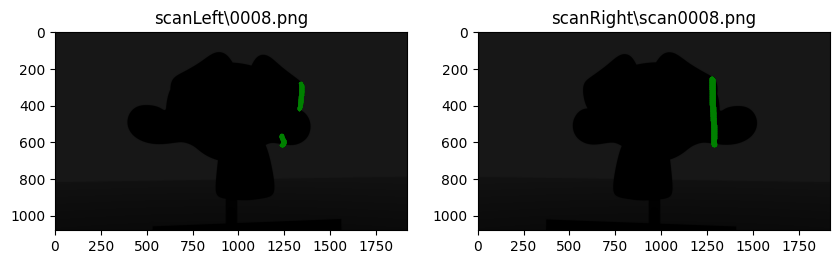

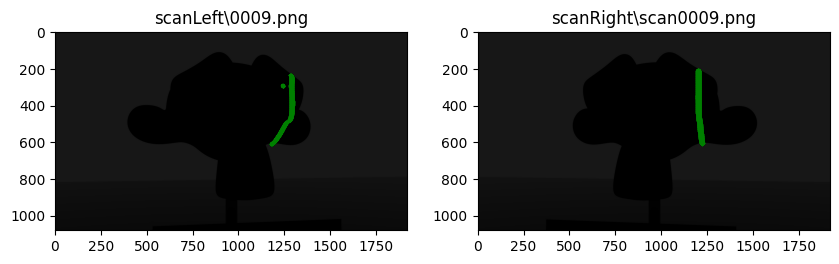

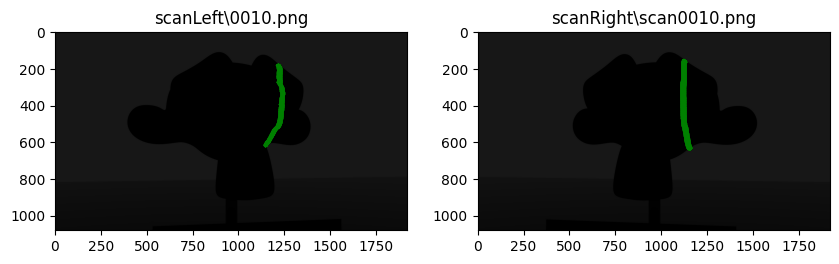

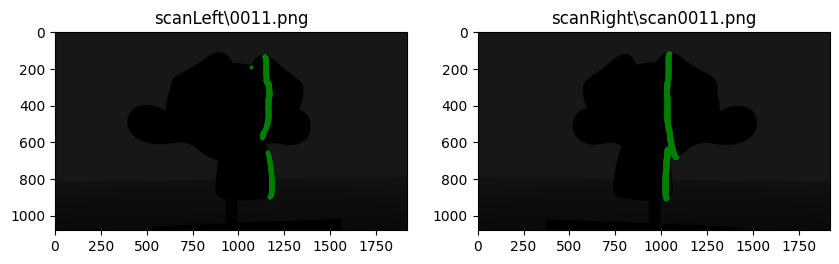

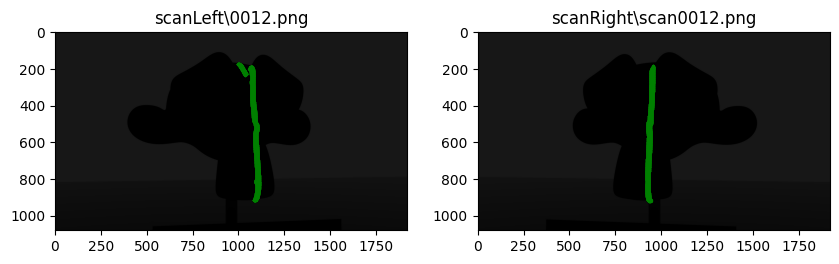

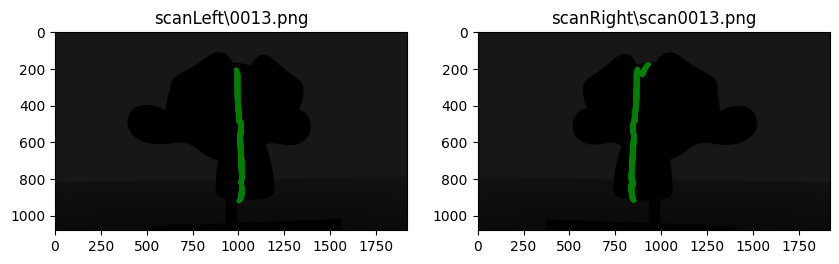

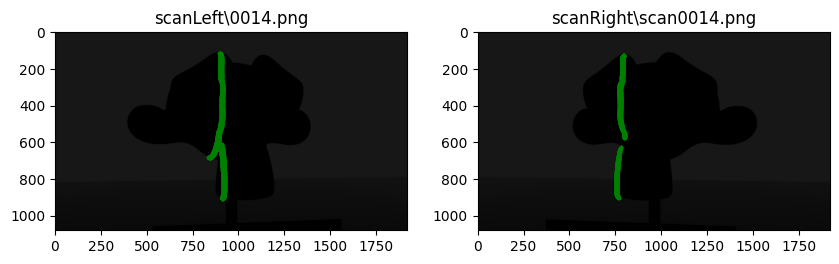

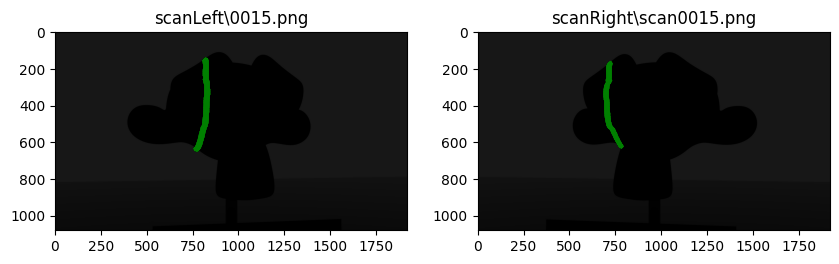

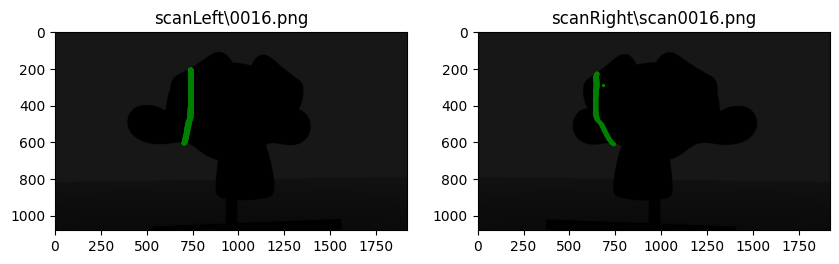

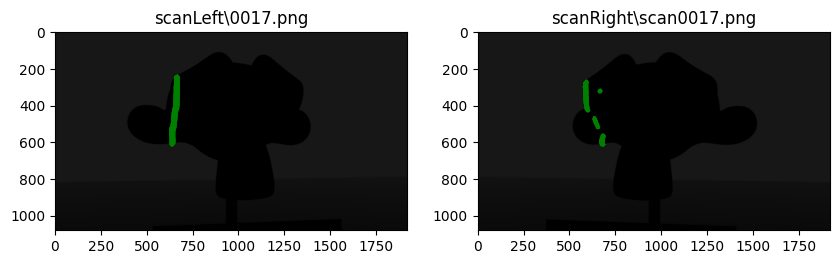

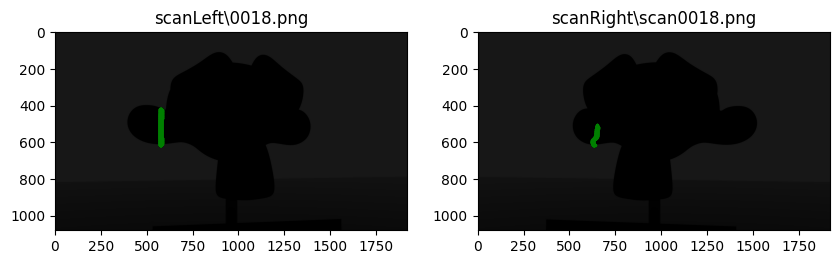

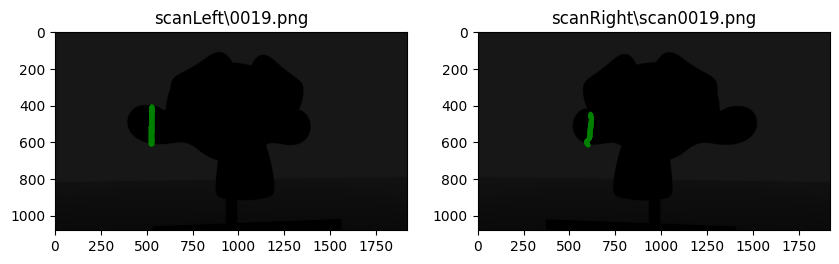

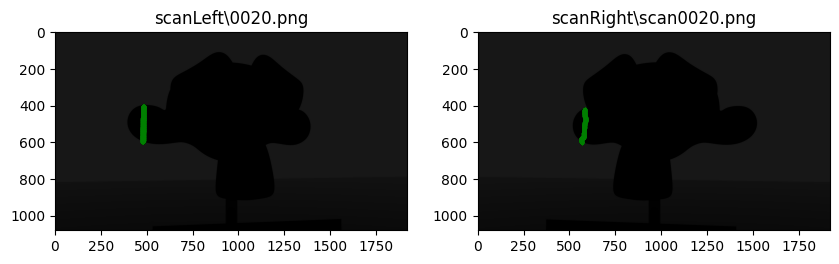

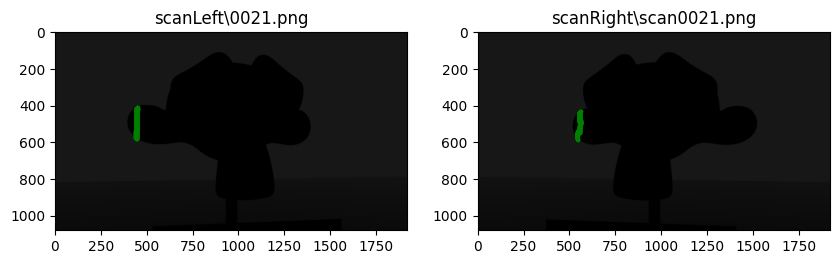

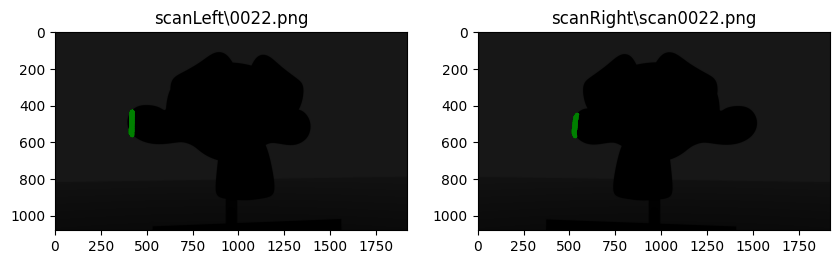

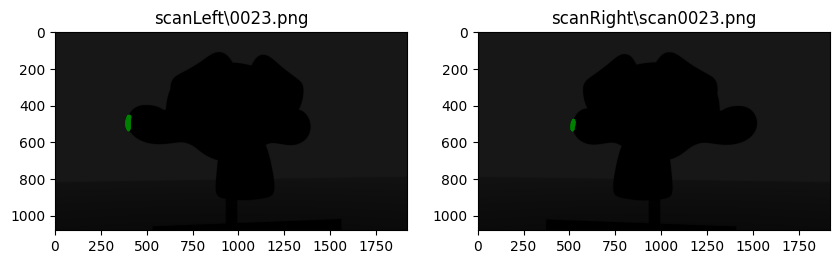

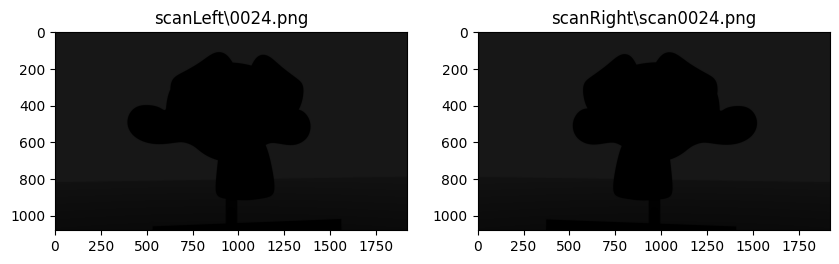

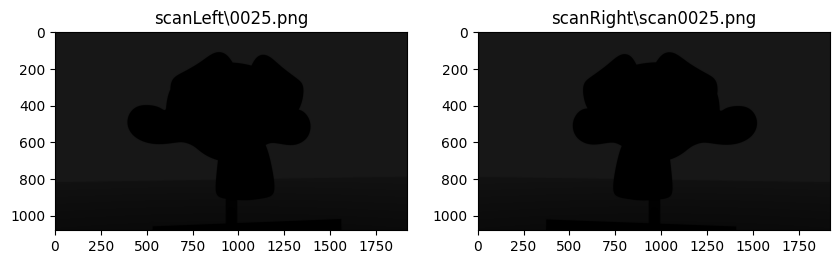

In [6]:
# Monkey images location
monkey_left_images = sorted(glob.glob('scanLeft/*.png'))
monkey_right_images = sorted(glob.glob('scanRight/*.png'))

# Placeholder for all red points
all_red_points_left = []
all_red_points_right = []

# Extract red pixels coordinates from image
def extract_red_pixels(image):
    # Convert to HSV for better red detection
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define red color ranges
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)
    
    # Find non-zero red pixel locations
    red_points = cv2.findNonZero(red_mask)
    if red_points is not None:
        red_points = np.squeeze(red_points)  # Remove unnecessary dimensions
    else:
        red_points = np.array([])  # Return empty array if no red pixels found
    return red_points

# Loop over every image pairs
for left_file, right_file in zip(monkey_left_images, monkey_right_images):
    # Read left and right images
    left_img = cv2.imread(left_file)
    right_img = cv2.imread(right_file)

    # Extract red points
    red_points_left = extract_red_pixels(left_img)
    red_points_right = extract_red_pixels(right_img)

    # Store red points
    all_red_points_left.append(red_points_left)
    all_red_points_right.append(red_points_right)

    # Plot the extracted points for debugging
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    if red_points_left.size > 0:
        plt.scatter(red_points_left[:, 0], red_points_left[:, 1], c='green', s=2)
    plt.title(left_file)

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
    if red_points_right.size > 0:
        plt.scatter(red_points_right[:, 0], red_points_right[:, 1], c='green', s=2)
    plt.title(right_file)
    plt.show()

## Step #5 : Epipolar Lines ✅

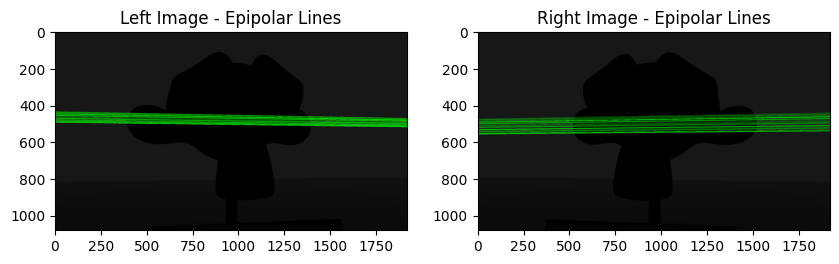

In [45]:
# Compute epipolar lines using fundamental matrix and a set of points
def compute_epipolar_lines(F, points, original_image):
    # Add a column of ones to make points homogeneous
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))
    
    # Compute epipolar lines (l = Fx)
    lines = np.dot(F, points_h.T).T  # Each row corresponds to a line [a, b, c] in ax + by + c = 0
    
    # Create a copy of the original image to draw lines on
    overlay_image = original_image.copy()
    for line in lines:
        a, b, c = line
        x1, y1 = 0, int(-c / b)  # Point at x=0
        x2, y2 = original_image.shape[1], int((-c - a * original_image.shape[1]) / b)  # Point at x=image width
        cv2.line(overlay_image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Draw green lines with thickness 1
    
    return lines, overlay_image


# Compute epipolar lines for the first image pair
points_left = all_red_points_left[3]
points_right = all_red_points_right[3]

if points_left.size > 0 and points_right.size > 0:
    # Number of epipolar lines
    num_points_to_sample = 40
    if points_left.shape[0] > num_points_to_sample:
        sampled_indices = np.random.choice(points_left.shape[0], num_points_to_sample, replace=False)
        points_left = points_left[sampled_indices]
        points_right = points_right[sampled_indices]
        
    # Compute and visualize epipolar lines
    lines_left, line_img_left = compute_epipolar_lines(F.T, points_right, left_img)
    lines_right, line_img_right = compute_epipolar_lines(F, points_left, right_img)
    
    # Show epipolar lines overlayed on original images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(line_img_left, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Left Image - Epipolar Lines")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(line_img_right, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Right Image - Epipolar Lines")
    plt.show()

In [15]:
def drawAvgPoint(fname,EplLeft):
    img = cv2.imread(fname)
    i = 0
    while i < len(EplLeft[0]):
        color = tuple(np.random.randint(0,255,3).tolist())
        img = cv2.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),10,color,-1)
        i += 4
    plt.imshow(img)
    plt.show()

'''equation of a ligne => returns a value for y for a given x and coefficients'''
def lineY(coefs,x):
    a,b,c = coefs
    return-(c+a*x)/b


def drawEpl(fname,EplRight):
    img = cv2.imread(fname)
    coef , length = EplRight.shape
    for i in range(0,length,20):
        #print a, b and c of epiline
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'g')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0010.png',epl[10][0])
drawEpl('scanRight/scan0010.png',epl[10][1])

NameError: name 'epl' is not defined

## Step #6 : Matching Pairs ✅/❌

## Step #7 : Triangulated 3D points ✅/❌

## Step #8 : 3D points cloud ✅/❌